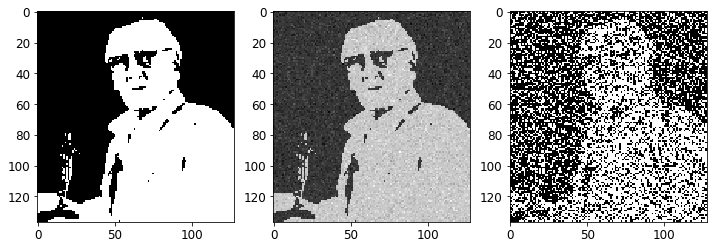

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import time
from imageio import imread


pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['font.size'] = 12

def add_gaussian_noise(im, prop, varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]   
    return im2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# proportion of pixels to alter
prop = 0.7
varSigma = 0.1

im = rgb2gray(imread('Graphics/stan_lee.png'))
im = np.array([np.round(x/255) for x in im])
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

prop= 1-prop
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

plt.show()

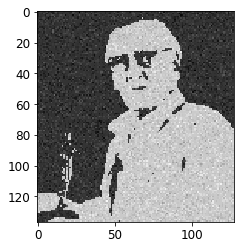

In [20]:
prop = 0.7
varSigma = 0.1
im4 = add_gaussian_noise(im,prop,varSigma)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im4,cmap='gray')

prop = 0.5
varSigma = 0.5
im5 = add_gaussian_noise(im,prop,varSigma)
ax3 = fig.add_subplot(132)
ax3.imshow(im5,cmap='gray')

prop = 0.3
varSigma = 1
im6 = add_gaussian_noise(im,prop,varSigma)
ax3 = fig.add_subplot(133)
ax3.imshow(im6,cmap='gray')

plt.show()
fig.savefig('Graphics/noises', bbox_inches='tight')

In [8]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1, N-1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2, N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        
        return n
    if size==8:
        n = [(i-1, j), (i-1, j-1), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j), (i+1,j-1), (i+1,j+1)]
        n = [(x, y) for (x, y) in n if 0 <= x <= M - 1 and 0 <= y <= N - 1]
        return n
            

In [9]:
def Li(x, y, eta=1):
#     return np.exp(-(x - y)**2)
    return eta*x*y

In [10]:
def p(x, y, w, M, N):
    prod = 1
    for i in range(0, M - 1):
        for j in range(0, N - 1):
            acc = 0
            for n in neighbours(i, j, M, N, size = 8):
                acc += w[i][j][n[0]][n[1]] * x[i][j] * x[n[0]][n[1]]
            esum = np.exp(acc)
            
            prod *= np.exp(Li(x[i][j], y[i][j])) * esum
    return prod

In [21]:
def image_denois_ICM(x0, y, T, M, N, xx, beta, eta):
    x = x0
    correctness1 = 0
    nsum = 0
    xysum = 0
    
    for i in range(0, M):
        for j in range(0, N):
            xysum += x[i][j] * y[i][j] 
            for (a, b) in neighbours(i, j, M, N, size = 8):
                nsum += x[i][j] * x[a][b]
    
    for t in range(0, T):        
        for i in range(0, M):
            for j in range(0, N):
                for (a,b) in neighbours(i, j, M, N, size = 8):
                    nsum += x[a][b] - (x[i][j]  * x[a][b])
                xysum += y[i][j] - x[i][j] * y[i][j]
                pp = beta * nsum + eta * xysum

                for (a,b) in neighbours(i, j, M, N, size = 8):
                    nsum -= 2 * x[a][b]
                xysum -= 2 * y[i][j]
                pn = beta * nsum + eta * xysum

                if pp > pn:
                    for (a,b) in neighbours(i, j, M, N, size = 8):
                        nsum += 2 * x[a][b] 
                    xysum += 2 * y[i][j]
                    x[i][j] = 1
                else:
                    x[i][j] = -1
        sum0 = 0
        for i in range (0,M):
            for j in range (0,N):
                if not((2*xx[i,j]-1)==x0[i,j]): 
                    sum0 += 1
        correctness = 1-sum0/(M*N)
        print (correctness)
        
        if correctness==correctness1:
            break
        correctness1 = correctness
    return x
                
                

0.7811359489051095


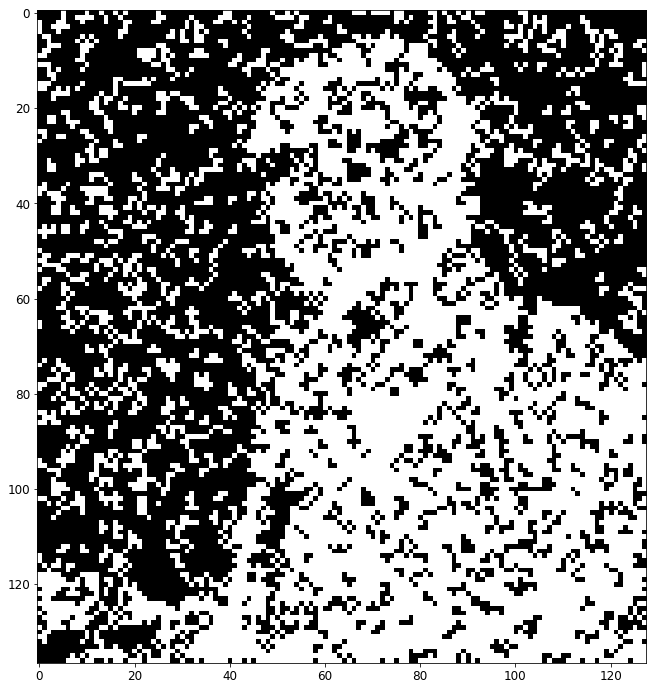

0.7811359489051095

In [23]:
y = im3
y = 2*y - 1


(M, N) = y.shape

timeicm = -time.time()
x = image_denois_ICM(y, y, 1, M, N, im, beta = 0.2, eta = 1.0)
timeicm += time.time()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(x,cmap='gray')

plt.show()
fig.savefig('Graphics/glitch.png', bbox_inches='tight')
1-np.sum(np.abs((x + 1) / 2 -im)) / (x.shape[0] * x.shape[1])

In [ ]:
def update_pixel(image,i,j,M,N, eta, beta):
    
    #getting neighbours for the node
    nbrhd = neighbours(i,j,M,N,8)
    #size of neighbourhood
    size = np.shape(nbrhd)[0]
    
    #initialising array of zeroes
    nbrhd_values = np.zeros(size)
    
    #Inserting values into array initialised above
    for k in range (size):
        nbrhd_values[k] = image[nbrhd[k]]
        
    centrePixel = image[i,j]
    
    pxminusone = eta * (centrePixel) * (-1)
    pxone = eta * (centrePixel)
    
    for value in nbrhd_values:
        pxone += beta * (value * 1)
        pxminusone += beta * (value * (-1))
    
    #initialising pxlValue
    pxlValue = centrePixel
    
    #comparing pxone and pxminus one and then updating the pxlValue
    if (pxone > pxminusone):
        pxlValue = 1
    elif (pxone < pxminusone):
        pxlValue = -1
    
    return pxlValue

### DELETE BELOW


im = rgb2gray(imread('Graphics/H.jpg'))
im6 = add_gaussian_noise(im, 0.7, 1)
plt.imshow(im6,cmap='gray')
plt.show()
y = 2*(im6+1)/3 -1
(M,N) = im.shape

eta = 1
beta = 0.1
x0=im
x_new = np.zeros((M,N))

for i in range (M):
    for j in range(N):
        x_new[i,j] = update_pixel(y,i,j,M,N, eta, beta)
y = x_new

for i in range (M):
    for j in range(N):
        x_new[i,j] = update_pixel(y,i,j,M,N, eta, beta)
y = x_new    
sum_new = 0
for i in range (0,M):
    for j in range (0,N):
        if ((2*x0[i,j]-1)==x_new[i,j]): 
            sum_new += 1
correctness = 1-sum_new/(M*N)
print (correctness)
plt.imshow(x_new, cmap='gray')

### DELETE ABOVE

In [ ]:
def gibbs_sampling(x0, y, T, M, N, xx, beta, eta):
    x = x0
    x_next = x0
    correctness1 = 0
    
    T=10
    etarange = 3
    steps = 10
    
    for eta in range (0,etarange):
        for beta in frange (0, eta, eta/steps):
            
    for t in range(0, T):        
        for i in range(0, M):
            for j in range(0, N):
                pp = eta * y[i][j] + beta * np.sum([x[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                pp = np.exp(pp)
                
                pn = eta * -y[i][j] + beta * np.sum([-x[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                pn = np.exp(pn)
                
                p = pp / (pp + pn)
                
                if p > np.random.uniform():
                    x_next[i][j] = 1
                else:
                    x_next[i][j] = -1
        sum0 = 0
        for i in range (0,M):
            for j in range (0,N):
                if not((2*xx[i,j]-1)==x0[i,j]): 
                    sum0 += 1
        correctness = 1-sum0/(M*N)
        if correctness==correctness1:
            break
        correctness1 = correctness
        char = "After " + str(t+1) + " iteration(s): " + str(np.round(correctness*100, decimals=20)) + "%"
        print (char)
        x = x_next
    return x     

In [ ]:
y = im6
y = 2*y - 1

(M, N) = y.shape

timeg = -time.time()
x = gibbs_sampling(np.zeros((M, N)), y, 15, M, N, im, beta = 0.25, eta = 0.8)
timeg += time.time()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(x,cmap='gray')

plt.show()

In [ ]:
def randGibbs(x0, y, T, M, N, beta, eta):
    np.random.seed(42)
    
    x = x0
    x_next = x0
    
    
                
    for t in range(0, T):
        i = np.random.randint(0, M, 1)
        j = np.random.randint(0, N, 1)
        pp = eta * y[i,j] + beta * np.sum([x[a,b] for (a, b) in neighbours(i, j, M, N, size = 8)])
        pp = np.exp(pp)

        pn = eta * -y[i,j] + beta * np.sum([-x[a,b] for (a, b) in neighbours(i, j, M, N, size = 8)])
        pn = np.exp(pn)

        p = pp / (pp + pn)

        if p > np.random.uniform():
            x_next[i,j] = 1
        else:
            x_next[i,j] = -1
            
        x = x_next
    return x  

In [ ]:
y = im6
y = 2*y - 1
(M, N) = y.shape

timerg = -time.time()
x = randGibbs(np.zeros((M, N)), y, 5*M*N, M, N, beta = 0.2, eta = 1)
timerg += time.time()

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(x,cmap='gray')

plt.show()
1-np.sum(np.abs((x + 1) / 2 -im)) / (x.shape[0] * x.shape[1])

In [12]:
#ALG 4: Mean Field Approx of p(X|Y)
def sigm (a):
    return 1/(1+np.exp(-a))

def MFVB (beta,eta, y, T, M, N, x):
    w = beta
    mu = y
    x0 = np.zeros((M,N))
    q = np.ones((M,N))
#     w = 0.03
    store = np.zeros((T))
    
    Ldiff = np.zeros ((M,N))
    
    for i in range (0,M):
        for j in range (0,N):
            
            Ldiff[i,j] = Li(1,y[i,j], eta) - Li(-1, y[i,j], eta)
        #endfor
    #endfor
#     f= open("efficacy.txt","a+")
#     f.write ("Denoise for beta=" + str(w) + ":\r\n")
    for t in range(0,T):
        for i in range (0,M):
            for j in range (0,N):
#                 i = np.random.randint(0, M, 1)
#                 j = np.random.randint(0, N, 1)
                msum = 0
                for (a,b) in neighbours(i, j, M, N, size = 8):
                    msum += w*mu[a,b]
                ai = msum + 0.5*(Ldiff[i,j])
                mu[i,j] = math.tanh(ai)
                if np.round(mu[i,j])==1:
                    q[i,j] = sigm(2*ai)
                    x0[i,j] = 1
                else:
                    q[i,j] = sigm(-2*ai)
                    x0[i,j] = -1
        
#         print (q)
#         prodq = 1     
#         for i in range (0,M):
#             for j in range (0,N):
#                 if q[i,j] == 0:
#                     print ("FAIL")
#                 else:
#                     prodq = prodq*q[i,j]
#         print (prodq)
        sum0 = 0
        for i in range (0,M):
            for j in range (0,N):
                if not((2*x[i,j]-1)==x0[i,j]): 
                    sum0 += 1
        correctness = 1-sum0/(M*N)
        store[t] = correctness
        char = "After " + str(t+1) + " iteration(s): " + str(np.round(correctness*100, decimals=20)) + "%"
        print (char)
#         f.write (char + "\r\n")
#     f.close()
        
    return x0, store

def rounding (x, M, N): 
    x0 = np.zeros((M,N))
    for i in range (M):
        for j in range (N):
            x0[i,j] = np.round(x[i,j])
            if x0[i,j] == 2:
                x0[i,j] = 1
            
    return x0 



0.7811359489051095
0.7913435218978102
0.7938526459854014
0.7952782846715328
0.7959625912408759
After 1 iteration(s): 84.5745894160584%
After 2 iteration(s): 85.56683394160584%
After 3 iteration(s): 85.90898722627738%
After 4 iteration(s): 86.10287408759125%
After 5 iteration(s): 86.17130474452554%


<Figure size 864x864 with 0 Axes>

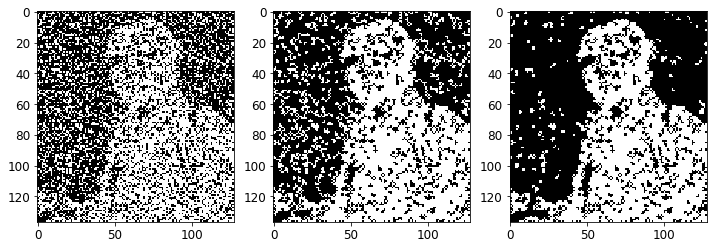

In [29]:
(M,N) = np.shape(im)
x0 = im

y = im3
y = 2*y -1

fig = plt.figure()


y = im3
y = 2*y - 1


(M, N) = y.shape

timeicm = -time.time()
x = image_denois_ICM(y, y, 5, M, N, im, beta = 0.2, eta = 1.0)
timeicm += time.time()
fig = plt.figure()
ax = fig.add_subplot(132)
ax.imshow(x,cmap='gray')

x, _ = MFVB(0.2,1, y,5,M,N,x0)
ax1 = fig.add_subplot(133)
ax1.imshow(x,cmap='gray')

ax3 = fig.add_subplot(131)
ax3.imshow(im3,cmap='gray')


# y = im5
# y = 2*y -1

# x, _ = MFVB(0.2,0.8, y,10,M,N,x0)
# ax3 = fig.add_subplot(132)
# ax3.imshow(x,cmap='gray')

# y = im6
# y = 2*y -1

# x, _ = MFVB(0.2,0.8, y,10,M,N,x0)
# ax3 = fig.add_subplot(133)
# ax3.imshow(x,cmap='gray')

plt.show()

In [14]:
# prop = 0.3
# varSigma = 0.5

# im6 = add_gaussian_noise(im,prop,varSigma)
# im6 = add_saltnpeppar_noise(im,prop)

im = rgb2gray(imread('Graphics/pyramid.jpg'))

im6 = add_saltnpeppar_noise(im, 0.8)

y=im6
y = 2*y -1
(M, N) = y.shape
x0 = im
time1 = -time.time()

beta = 0.1
eta = 3
T=10
num = 5

eta_store = np.zeros((num,T))
x_store = np.zeros((num,M,N))

ratio = 8/32
                   
for i in range (3,len(eta_store)):
    print (i)
    eta = i
    beta = eta*ratio
    x0 = im
    y=im6
    y = 2*y -1
    x_store[i], eta_store[i] = MFVB(beta,eta, y,T,M,N,x0)

# x1= MFVB(beta,eta, y,5,M,N,x0)
time1 += time.time()

# y=im6
# y = 2*y -1
# beta= 0.2
# eta = 12
# x2 = MFVB(beta, eta, y,5,M,N,x0)

# y=im6
# y = 2*y -1
# beta = 0.3
# eta = 18
# x3 = MFVB(beta, eta, y,5,M,N,x0)

# print (y)
# x4 = rounding (y, M, N)
# print (x4)
# x4 = MFVB(beta,y,5,M,N)
# x5 = MFVB(beta, y,8,M,N)
# x5 = MFVB(beta, y,10,M,N)
# x5 = MFVB(beta, y,8,M,N)



3
After 1 iteration(s): 9.477306547619047%
After 2 iteration(s): 8.184523809523814%
After 3 iteration(s): 7.235863095238094%
After 4 iteration(s): 6.9010416666666625%
After 5 iteration(s): 6.742931547619047%
After 6 iteration(s): 6.5848214285714315%
After 7 iteration(s): 6.5104166666666625%
After 8 iteration(s): 6.5104166666666625%
After 9 iteration(s): 6.491815476190475%
After 10 iteration(s): 6.47321428571429%
4
After 1 iteration(s): 9.468005952380953%
After 2 iteration(s): 8.128720238095234%
After 3 iteration(s): 7.217261904761907%
After 4 iteration(s): 6.919642857142859%
After 5 iteration(s): 6.761532738095233%
After 6 iteration(s): 6.649925595238093%
After 7 iteration(s): 6.5755208333333375%
After 8 iteration(s): 6.547619047619047%
After 9 iteration(s): 6.519717261904766%
After 10 iteration(s): 6.5104166666666625%


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

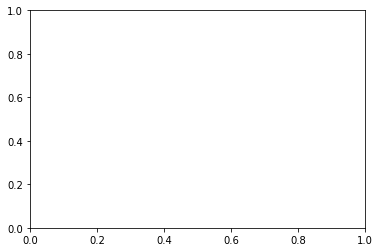

In [13]:
### print (eta_store)
for i in range (2, len(eta_store)):
    plt.plot([1,2,3,4,5], 100*eta_store[i])
plt.ylabel('Correct pixels in denoised image/%',fontsize=30)
# plt.title('Different values of beta and eta with ratio 1:30',)


In [ ]:
sum0 = 0
for i in range (0,M):
    for j in range (0,N):
        if not((2*x4[i,j]-1)==x0[i,j]): 
            sum0 += 1
correctness = 1-sum0/(M*N)
print (correctness)


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot (132)
ax3 = fig.add_subplot (133)
# ax4 = fig.add_subplot (234)

ax1.imshow(x1,cmap='gray')
ax2.imshow(x2,cmap='gray')
ax3.imshow(x3,cmap='gray')
# ax4.imshow(x4,cmap='gray')

plt.show()
print (y.shape)

In [ ]:
def nestedgibbs_sampling(x0, y, T, M, N, beta, eta):
    x = x0
    x_next = x0
                
    for t in range(0, T):        
        for i in range(0, M):
            for j in range(0, N):
                
                nhood = np.zeros((8))
                for (c,d) in neighbours(i,j,M,N,size=8):
                    pp = eta * y[c][d] + beta * np.sum([x[a][b] for (a, b) in neighbours(c, d, M, N, size = 8)])
                    pp = np.exp(pp)
                    
                    pn = eta * -y[c][d] + beta * np.sum([-x[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                    pn = np.exp(pn)
                    
                    p = pp / (pp + pn)
                    
                    if p > np.random.uniform():
                        x_next[c][d] = 1
                    else:
                        x_next[c][d] = -1
                
                pp = eta * y[i][j] + beta * np.sum([x_next[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                pp = np.exp(pp)
                
                pn = eta * -y[i][j] + beta * np.sum([-x_next[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                pn = np.exp(pn)
                
                p = pp / (pp + pn)
                
                if p > np.random.uniform():
                    x_next[i][j] = 1
                else:
                    x_next[i][j] = -1
        
        x = x_next
    return x     

In [ ]:
y = im6
y = 2*y - 1

(M, N) = y.shape

timeg = -time.time()
x = nestedgibbs_sampling(np.zeros((M, N)), y, 15, M, N, beta = 0.25, eta = 0.8)
timeg += time.time()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(x,cmap='gray')

plt.show()
1-np.sum(np.abs((x + 1) / 2 -im)) / (x.shape[0] * x.shape[1])

In [ ]:
print (timeicm)
print (timeg)
print (timerg)
print (time1)